# 14_SSB_data_cleaning

## Administrative borders, population, crime rates, etc

Plan:
- Load population + crime data -> clean up (evt. in excel if needed)
- Load administrative borders -> join everything together
- export to geopackage or shapefile or geojson

DataWrangeler notes:
- Save Pandas Dataframes as CSV
- Save anything with geometry as GeoJSON, GeoPackage or Shapefile
- column types are not read from CSV, so you need to specify them when reading the CSV


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely
from pyproj import Transformer
import geopandas as gpd
import openpyxl

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [13]:
# Load population from file: data\SSB_norway_12.03.24\befolkning_kommune_cleaned.csv
population_gdf = gpd.read_file('../data/SSB_norway_12.03.24/befolkning_kommune_cleaned.csv')
population_gdf.dtypes

kommuneID              object
kommuneNavn            object
befolkning             object
befolkning_pr_km2      object
geometry             geometry
dtype: object

In [14]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(population_gdf):
    # Change column type to int64 for column: 'kommuneID'
    population_gdf = population_gdf.astype({'kommuneID': 'int64'})
    # Change column type to string for column: 'kommuneNavn'
    population_gdf = population_gdf.astype({'kommuneNavn': 'string'})
    # Change column type to int64 for column: 'befolkning'
    population_gdf = population_gdf.astype({'befolkning': 'int64'})
    # Change column type to int64 for column: 'befolkning_pr_km2'
    population_gdf = population_gdf.astype({'befolkning_pr_km2': 'int64'})
    # Drop column: 'geometry'
    population_gdf = population_gdf.drop(columns=['geometry'])
    return population_gdf

population_gdf_clean = clean_data(population_gdf.copy())


In [17]:
population_gdf_clean.dtypes

kommuneID                     int64
kommuneNavn          string[python]
befolkning                    int64
befolkning_pr_km2             int64
dtype: object

In [18]:
# Load crime data
crime_gdf = gpd.read_file('../data/SSB_norway_12.03.24/SSB_2021-22_anmeldteLovbrudd_cleaned.csv')
crime_gdf.dtypes

fylkeID                    object
kommuneID                  object
kommuneNavn                object
anmeldteLovbrudd(avg)      object
geometry                 geometry
dtype: object

In [ ]:
crime_gdf

In [20]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(crime_gdf):
    # Drop column: 'geometry'
    crime_gdf = crime_gdf.drop(columns=['geometry'])
    # Change column type to int64 for column: 'anmeldteLovbrudd(avg)'
    crime_gdf = crime_gdf.astype({'anmeldteLovbrudd(avg)': 'int64'})
    # Change column type to string for column: 'kommuneNavn'
    crime_gdf = crime_gdf.astype({'kommuneNavn': 'string'})
    # Change column type to int64 for column: 'kommuneID'
    crime_gdf = crime_gdf.astype({'kommuneID': 'int64'})
    # Change column type to int64 for column: 'fylkeID'
    crime_gdf = crime_gdf.astype({'fylkeID': 'int64'})
    # Rename column 'fylkeID' to 'fylkeID_old'
    crime_gdf = crime_gdf.rename(columns={'fylkeID': 'fylkeID_old'})
    # Rename column 'kommuneID' to 'kommuneID_old'
    crime_gdf = crime_gdf.rename(columns={'kommuneID': 'kommuneID_old'})
    # Change column type to object for column: 'fylkeID_old'
    crime_gdf = crime_gdf.astype({'fylkeID_old': 'object'})
    # Change column type to string for column: 'kommuneNavn'
    crime_gdf = crime_gdf.astype({'kommuneNavn': 'string'})
    # Change column type to int64 for column: 'fylkeID_old'
    crime_gdf = crime_gdf.astype({'fylkeID_old': 'int64'})
    # Rename column 'fylkeID_old' to 'fylkeID'
    crime_gdf = crime_gdf.rename(columns={'fylkeID_old': 'fylkeID'})
    # Rename column 'kommuneID_old' to 'kommuneID'
    crime_gdf = crime_gdf.rename(columns={'kommuneID_old': 'kommuneID'})
    return crime_gdf

crime_gdf_clean = clean_data(crime_gdf.copy())
crime_gdf_clean.head(10)

,fylkeID,kommuneID,kommuneNavn,anmeldteLovbrudd(avg)
0,99999,99999,gjerningssted,0
1,99999,99999,alt i alt,291727
2,0,0,0 Hele landet,286516
3,0,0,00 Alle fylker,285638
4,0,0,Alle kommuner,284509
5,30,30,30 Viken,62678
6,30,3001,Halden,2968
7,30,3002,Moss,2963
8,30,3003,Sarpsborg,3266
9,30,3004,Fredrikstad,4722


In [21]:
# create a new dataframe that drops the first 6 rows
crime_gdf_clean_new = crime_gdf_clean.drop([0, 1, 2, 3, 4, 5])
crime_gdf_clean_new.head(10)

,fylkeID,kommuneID,kommuneNavn,anmeldteLovbrudd(avg)
6,30,3001,Halden,2968
7,30,3002,Moss,2963
8,30,3003,Sarpsborg,3266
9,30,3004,Fredrikstad,4722
10,30,3005,Drammen,5713
11,30,3006,Kongsberg,958
12,30,3007,Ringerike,1368
13,30,3011,Hvaler,179
14,30,3012,Aremark,78
15,30,3013,Marker,450


In [26]:
# show the dataframe and sort by kommuneID ascending
crime_gdf_clean_new.sort_values(by=['kommuneID'], ascending=True)
crime_gdf_clean_new.dtypes

fylkeID                           int64
kommuneID                         int64
kommuneNavn              string[python]
anmeldteLovbrudd(avg)             int64
dtype: object

In [27]:
# convert kommuneID to string first
crime_gdf_clean_new = crime_gdf_clean_new.astype({'kommuneID': 'string'})

# delete all rows where kommuneID is 2 numeric values. Only 4 numeric values are allowed
crime_gdf_clean_new = crime_gdf_clean_new[crime_gdf_clean_new.kommuneID.str.len() == 4]
crime_gdf_clean_new.sort_values(by=['kommuneID'], ascending=True)

,fylkeID,kommuneID,kommuneNavn,anmeldteLovbrudd(avg)
161,11,1101,Eigersund,649
162,11,1103,Stavanger,8570
163,11,1106,Haugesund,2546
164,11,1108,Sandnes,4192
165,11,1111,Sokndal,70
...,...,...,...,...
376,54,5441,Deatnu - Tana,137
377,54,5442,Unjárga - Nesseby,55
378,54,5443,Båtsfjord,99
379,54,5444,Sør-Varanger,542


In [30]:
# convert kommuneID to int64 again
crime_gdf_clean_new = crime_gdf_clean_new.astype({'kommuneID': 'int64'})
print("type of crime_gdf_clean_new: ", type(crime_gdf_clean_new))
crime_gdf_clean_new.dtypes

type of crime_gdf_clean_new:  <class 'pandas.core.frame.DataFrame'>


fylkeID                           int64
kommuneID                         int64
kommuneNavn              string[python]
anmeldteLovbrudd(avg)             int64
dtype: object

In [29]:
crime_gdf_clean_new.head(2)

,fylkeID,kommuneID,kommuneNavn,anmeldteLovbrudd(avg)
6,30,3001,Halden,2968
7,30,3002,Moss,2963


Okay, ready to merge the population and crime data sets.   
MAYBE check if the kommuneNames will match perfectly with the Excel files (in that case import and map the names correctly)

In [31]:
print("type of population_gdf_clean: ", type(population_gdf_clean))
population_gdf_clean.head(2)

type of population_gdf_clean:  <class 'pandas.core.frame.DataFrame'>


,kommuneID,kommuneNavn,befolkning,befolkning_pr_km2
0,3101,Halden,31935,54
1,3103,Moss,52051,407


In [33]:
# full outer join between population_gdf_clean and crime_gdf_clean_new
merged_df = pd.merge(population_gdf_clean, crime_gdf_clean_new, on='kommuneID', how='outer')
merged_df.head(10)

,kommuneID,kommuneNavn_x,befolkning,befolkning_pr_km2,fylkeID,kommuneNavn_y,anmeldteLovbrudd(avg)
0,301,Oslo,717710.000,1683.000,NaN,<NA>,NaN
1,1101,Eigersund,15221.000,39.000,11.000,Eigersund,649.000
2,1103,Stavanger,149048.000,582.000,11.000,Stavanger,8570.000
3,1106,Haugesund,38292.000,560.000,11.000,Haugesund,2546.000
4,1108,Sandnes,83702.000,89.000,11.000,Sandnes,4192.000
5,1111,Sokndal,3347.000,13.000,11.000,Sokndal,70.000
6,1112,Lund,3226.000,9.000,11.000,Lund,67.000
7,1114,Bjerkreim,2892.000,5.000,11.000,Bjerkreim,79.000
8,1119,Hå,19827.000,80.000,11.000,Hå,675.000
9,1120,Klepp,20900.000,204.000,11.000,Klepp,737.000


In [34]:
### The full outer join was successful, however the cleaning will continue in Excel

"""
Cell generated by Data Wrangler.
"""
def clean_data(merged_df):
    # Rename column 'kommuneNavn_x' to 'kommuneNavn_2024'
    merged_df = merged_df.rename(columns={'kommuneNavn_x': 'kommuneNavn_2024'})
    # Drop column: 'fylkeID'
    merged_df = merged_df.drop(columns=['fylkeID'])
    return merged_df

merged_df_clean = clean_data(merged_df.copy())
merged_df_clean.head()

,kommuneID,kommuneNavn_2024,befolkning,befolkning_pr_km2,kommuneNavn_y,anmeldteLovbrudd(avg)
0,301,Oslo,717710.000,1683.000,<NA>,NaN
1,1101,Eigersund,15221.000,39.000,Eigersund,649.000
2,1103,Stavanger,149048.000,582.000,Stavanger,8570.000
3,1106,Haugesund,38292.000,560.000,Haugesund,2546.000
4,1108,Sandnes,83702.000,89.000,Sandnes,4192.000


In [38]:
# export as excel file
merged_df_clean.to_excel('population_crime_OuterJoin.xlsx', index=False)

# export as csv file
merged_df_clean.to_csv('population_crime_OuterJoin.csv', index=False)

In [43]:
# import cleaned CSV data from Excel - remember it has norwegian characters, so encoding must be set to iso-8859-1
merged_df_clean = pd.read_csv('population_crime_OuterJoin_cleaned.csv', encoding='iso-8859-1')
merged_df_clean.head(2)

,kommuneID,kommuneNavn_2024,befolkning,befolkning_pr_km2,kommuneNavn_y,anmeldteLovbrudd(avg)
0,301,Oslo,717710,1683,NaN,59973
1,1101,Eigersund,15221,39,Eigersund,649


In [47]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(merged_df_clean):
    # Drop column: 'kommuneNavn_y'
    merged_df_clean = merged_df_clean.drop(columns=['kommuneNavn_y'])
    # Rename column 'kommuneNavn_2024' to 'kommuneNavn'
    merged_df_clean = merged_df_clean.rename(columns={'kommuneNavn_2024': 'kommuneNavn'})
    return merged_df_clean

merged_df_clean_1 = clean_data(merged_df_clean.copy())
merged_df_clean_1.head()

,kommuneID,kommuneNavn,befolkning,befolkning_pr_km2,anmeldteLovbrudd(avg)
0,301,Oslo,717710,1683,59973
1,1101,Eigersund,15221,39,649
2,1103,Stavanger,149048,582,8570
3,1106,Haugesund,38292,560,2546
4,1108,Sandnes,83702,89,4192


OKAY, Population data + crime data have been successfully merged and cleaned.  

Next up is to load the administrative borders and join everything together.

In [45]:
# load administrative boundaries from geojson file
borders = gpd.read_file('../data/SSB_norway_12.03.24/epsg32633_utm33n_geojson/kommune.geojson')
borders.head(2)

,kommunenummer,kommunenavn,geometry
0,4216,Birkenes,"MULTIPOLYGON (((101595.61113 6518339.12902, 10..."
1,5053,Inderøy,"MULTIPOLYGON (((309171.84212 7096129.14673, 30..."


In [48]:
# rename to columns: kommuneID, kommuneNavn
borders = borders.rename(columns={'kommunenummer': 'kommuneID', 'kommunenavn': 'kommuneNavn'})
borders.head(2)

,kommuneID,kommuneNavn,geometry
0,4216,Birkenes,"MULTIPOLYGON (((101595.61113 6518339.12902, 10..."
1,5053,Inderøy,"MULTIPOLYGON (((309171.84212 7096129.14673, 30..."


In [50]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(borders):
    # Change column type to int64 for column: 'kommuneID'
    borders = borders.astype({'kommuneID': 'int64'})
    # Change column type to string for column: 'kommuneNavn'
    borders = borders.astype({'kommuneNavn': 'string'})
    return borders

borders_clean = clean_data(borders.copy())
borders_clean.head()

,kommuneID,kommuneNavn,geometry
0,4216,Birkenes,"MULTIPOLYGON (((101595.61113 6518339.12902, 10..."
1,5053,Inderøy,"MULTIPOLYGON (((309171.84212 7096129.14673, 30..."
2,3440,Øyer,"MULTIPOLYGON (((243262.69004 6812689.84001, 24..."
3,4014,Kragerø,"MULTIPOLYGON (((181548.00015 6546623.33984, 18..."
4,4226,Hægebostad,"MULTIPOLYGON (((50960.31337 6515113.54778, 509..."


In [52]:
# merge the borders with the cleaned data, and do full outer join to verify we have all the data
borders_merged = pd.merge(borders_clean, merged_df_clean_1, on='kommuneID', how='outer')
borders_merged.head(2)

,kommuneID,kommuneNavn_x,geometry,kommuneNavn_y,befolkning,befolkning_pr_km2,anmeldteLovbrudd(avg)
0,301,Oslo,"MULTIPOLYGON (((260102.43000 6645441.70742, 26...",Oslo,717710,1683,59973
1,1101,Eigersund,"MULTIPOLYGON (((-21958.16651 6520966.52376, -2...",Eigersund,15221,39,649


In [54]:
# drop the rows where kommuneID=4299 and kommuneID=4699
borders_merged_new = borders_merged[borders_merged.kommuneID != 4299]
borders_merged_new = borders_merged[borders_merged.kommuneID != 4699]
borders_merged_new.head(2)

,kommuneID,kommuneNavn_x,geometry,kommuneNavn_y,befolkning,befolkning_pr_km2,anmeldteLovbrudd(avg)
0,301,Oslo,"MULTIPOLYGON (((260102.43000 6645441.70742, 26...",Oslo,717710,1683,59973
1,1101,Eigersund,"MULTIPOLYGON (((-21958.16651 6520966.52376, -2...",Eigersund,15221,39,649


In [58]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(borders_merged_new):
    # Drop column: 'kommuneNavn_y'
    borders_merged_new = borders_merged_new.drop(columns=['kommuneNavn_y'])
    # Rename column 'kommuneNavn_x' to 'kommuneNavn'
    borders_merged_new = borders_merged_new.rename(columns={'kommuneNavn_x': 'kommuneNavn'})
    # Change column type to string for column: 'kommuneNavn'
    borders_merged_new = borders_merged_new.astype({'kommuneNavn': 'string'})
    return borders_merged_new

borders_merged_new_clean = clean_data(borders_merged_new.copy())
borders_merged_new_clean.head()

,kommuneID,kommuneNavn,geometry,befolkning,befolkning_pr_km2,anmeldteLovbrudd(avg)
0,301,Oslo,"MULTIPOLYGON (((260102.43000 6645441.70742, 26...",717710,1683,59973
1,1101,Eigersund,"MULTIPOLYGON (((-21958.16651 6520966.52376, -2...",15221,39,649
2,1103,Stavanger,"MULTIPOLYGON (((-29201.11114 6570959.10112, -2...",149048,582,8570
3,1106,Haugesund,"MULTIPOLYGON (((-49124.12262 6623149.94947, -4...",38292,560,2546
4,1108,Sandnes,"MULTIPOLYGON (((-22245.70532 6554013.46339, -2...",83702,89,4192


In [65]:
borders_merged_new_clean.dtypes

kommuneID                         int64
kommuneNavn              string[python]
geometry                       geometry
befolkning                        int64
befolkning_pr_km2                 int64
anmeldteLovbrudd(avg)             int64
dtype: object

In [62]:
# save the data that now has geometry to a new file
# the ideal formates are: .shp, .geojson, .gpkg
borders_merged_new_clean.to_file('borders_population_crime_complete.geojson', driver='GeoJSON')

In [69]:
# import and inspect the new file
borders_population_crime_complete = gpd.read_file('borders_population_crime_complete.geojson')
print("crs: ", borders_population_crime_complete.crs)
borders_population_crime_complete.head(2)

crs:  EPSG:4326


,kommuneID,kommuneNavn,befolkning,befolkning_pr_km2,anmeldteLovbrudd(avg),geometry
0,301,Oslo,717710,1683,59973,"MULTIPOLYGON (((260102.43000 6645441.70742, 26..."
1,1101,Eigersund,15221,39,649,"MULTIPOLYGON (((-21958.16651 6520966.52376, -2..."


In [70]:
# Manually set the crs to EPSG:32633
borders_population_crime_complete = borders_population_crime_complete.set_crs("EPSG:32633", allow_override=True)
print("borders_population_crime_complete crs:", borders_population_crime_complete.crs)
borders_population_crime_complete.head(2)

borders_population_crime_complete crs: EPSG:32633


,kommuneID,kommuneNavn,befolkning,befolkning_pr_km2,anmeldteLovbrudd(avg),geometry
0,301,Oslo,717710,1683,59973,"MULTIPOLYGON (((260102.430 6645441.707, 260388..."
1,1101,Eigersund,15221,39,649,"MULTIPOLYGON (((-21958.167 6520966.524, -21980..."


In [71]:
borders_population_crime_complete.dtypes

kommuneID                   int64
kommuneNavn                object
befolkning                  int64
befolkning_pr_km2           int64
anmeldteLovbrudd(avg)       int64
geometry                 geometry
dtype: object

In [82]:
borders_population_crime_complete.columns

Index(['kommuneID', 'kommuneNavn', 'befolkning', 'befolkning_pr_km2',
       'anmeldteLovbrudd(avg)', 'geometry'],
      dtype='object')

In [83]:
# rename columns from: ['kommuneID', 'kommuneNavn', 'befolkning', 'befolkning_pr_km2', 'anmeldteLovbrudd(avg)', 'geometry']
# to: ['municipalityID', 'municipalityName', 'population', 'populationPerKm2', 'reportedOffences', 'geometry']
borders_population_crime_complete = borders_population_crime_complete.rename(columns={'kommuneID': 'municipalityID', 'kommuneNavn': 'municipalityName', 'befolkning': 'population', 'befolkning_pr_km2': 'populationPerKm2', 'anmeldteLovbrudd(avg)': 'reportedOffences'})
borders_population_crime_complete.head(2)

,municipalityID,municipalityName,population,populationPerKm2,reportedOffences,geometry
0,301,Oslo,717710,1683,59973,"MULTIPOLYGON (((260102.430 6645441.707, 260388..."
1,1101,Eigersund,15221,39,649,"MULTIPOLYGON (((-21958.167 6520966.524, -21980..."


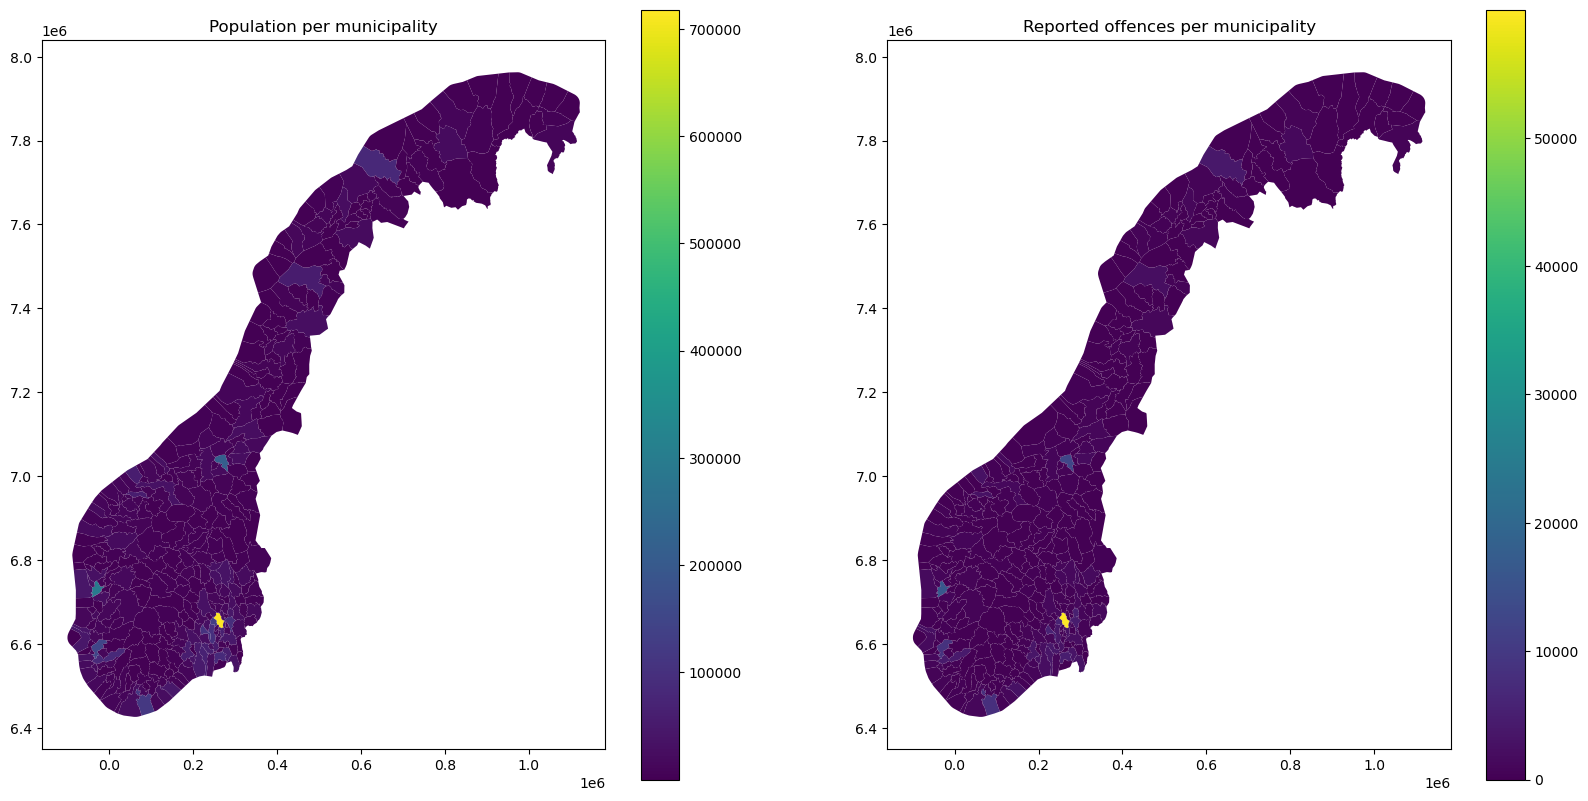

In [93]:
# Make a subplot with 1 row and 2 columns of the population and crime data. Height=10, width=10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
borders_population_crime_complete.plot(column='population', cmap='viridis', ax=ax1, legend=True)
ax1.set_title('Population per municipality')
borders_population_crime_complete.plot(column='reportedOffences', cmap='viridis', ax=ax2, legend=True)
ax2.set_title('Reported offences per municipality')
plt.show()

It appears that for the municipalities, the reportedOffences correlates with the population.  
Therefore, we should investigate the correlation further with an exploratory data analysis.

correlation between population and reported offences:  0.9788775942378916


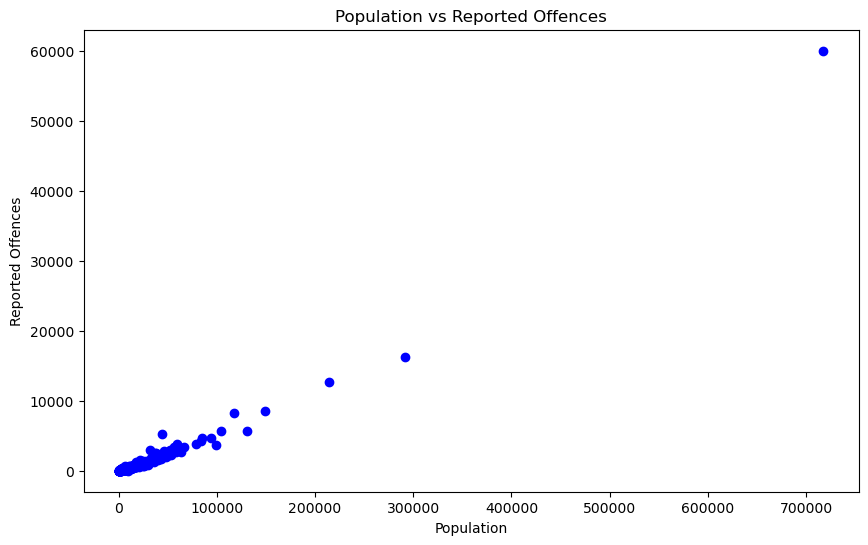

In [94]:
# Exploratory Data Analysis (EDA)

## Correlation between population and reported offences
correlation = borders_population_crime_complete['population'].corr(borders_population_crime_complete['reportedOffences'])
print("correlation between population and reported offences: ", correlation)

# Create a scatter plot of population and reported offences
plt.figure(figsize=(10, 6))
plt.scatter(borders_population_crime_complete['population'], borders_population_crime_complete['reportedOffences'], color='blue')
plt.title('Population vs Reported Offences')
plt.xlabel('Population')
plt.ylabel('Reported Offences')
plt.show()
